## Assists Only analysis

Here, we will test both total assists and assists per minute in relation to chances of winning a game

First, our import statements

In [1]:
from dotenv import load_dotenv
import requests
import os
import json
import mysql.connector
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

Next, lets setup our DB connection using a .env file.

In [2]:
%load_ext dotenv
%dotenv

mydb = mysql.connector.connect(
    host = os.getenv('CRUC_DB_HOST'),
    user = os.getenv('CRUC_DB_USER'),
    passwd = os.getenv('CRUC_DB_PASSWD'),
    database = os.getenv('CRUC_DATABASE'),
    auth_plugin='mysql_native_password',
    pool_name='crucible_pool',
    pool_size=5
)
mycursor = mydb.cursor()

Now, let's grab the data and store it in a dataframe.

In [3]:
# get first 1000 rows from DB.
sql = f'SELECT * FROM `matches` LIMIT 1000;'
mycursor.execute(sql)
sqlreturn = mycursor.fetchall()
mydb.close()

# convert to DF 
df = pd.DataFrame(sqlreturn, columns = ['id', 'instanceId', 'team', 'kills', 'deaths', 'assists', 'members', 'duration', 'standing'])
df.head()

,id,instanceId,team,kills,deaths,assists,members,duration,standing
0,1,6494000521,0,38,28,9,3,883,0
1,2,6494000521,1,28,39,7,3,883,1
2,3,6494000682,0,10,33,2,3,468,1
3,4,6494000682,1,33,10,11,3,468,0
4,5,6494002122,0,36,28,12,3,881,0


Let's remove some outliers like standing = 3 or matches shorter than 2 minutes and remove some unneaded columns including kills and deaths since we are only looking at assists.

In [5]:
df = df[df.standing != 3]
df = df[df.duration > 120]
df = df.drop(['id', 'instanceId','kills','deaths','team','members'], 1)
df = df.reset_index(drop=True)
df.head()

KeyError: "['id' 'instanceId' 'kills' 'deaths' 'team' 'members'] not found in axis"

Let's create a df with our kills, deaths, and assists adjusted to be per minute instead of per match

In [6]:
minute_df = df.copy()
minute_df['assists'] = minute_df['assists']/(minute_df['duration']/60)
minute_df.head()

,assists,duration,standing
0,0.611552,883,0
1,0.475651,883,1
2,0.256410,468,1
3,1.410256,468,0
4,0.817253,881,0


Let's remove the duration column since we no longer need it

In [7]:
df = df.drop(['duration'], 1)
df = df.reset_index(drop=True)
minute_df = minute_df.drop(['duration'], 1)
minute_df = minute_df.reset_index(drop=True)

So, most of the data is self explanetory.  Standing represents win/loss.  0 = win, 1 = loss.  We don't need the id, instanceId, team, or duration fields so let's drop those columns.  Let's also remove any rows where standing != 1 or 2 and duration < 120 to avoid those outliers

## Visualize 

Let's visualize kills and assists vs wins

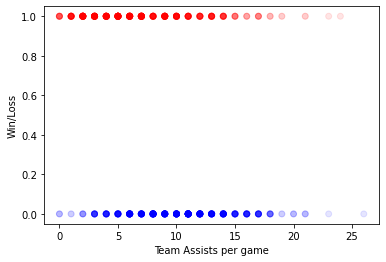

In [10]:
col = np.where(df.standing==0,'b','r')
plt.scatter(df.assists, df.standing,  color=col, alpha=.1)
plt.xlabel("Team Assists per game")
plt.ylabel("Win/Loss")
plt.show()

Let's look at team Assists per minute

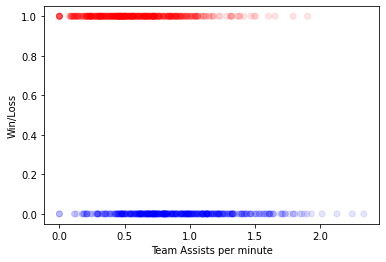

In [11]:
plt.scatter(minute_df.assists, minute_df.standing,  color=col, alpha=.1)
plt.xlabel("Team Assists per minute")
plt.ylabel("Win/Loss")
plt.show()

## Create and Test Both Models

In [18]:
X = np.asarray(df[['assists']])
X_min = np.asarray(minute_df[['assists']])
y = np.asarray(df['standing'])

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
X_train_min, X_test_min, y_train, y_test = train_test_split( X_min, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (772, 1) (772,)
Test set: (193, 1) (193,)


Now, we need to create and train our model

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
model = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
minute_model = LogisticRegression(C=0.01, solver='liblinear').fit(X_train_min,y_train)

Now, we can create two lists with predicted outcome and probability of outcome

In [22]:
yhat = model.predict(X_test)
yhat_prob = model.predict_proba(X_test)

yhat_min = minute_model.predict(X_test_min)
yhat_prob_min = minute_model.predict_proba(X_test_min)

Let's check the Jaccard index for accuracy

In [23]:
from sklearn.metrics import jaccard_score
print(f'Jaccard for per game: {jaccard_score(y_test, yhat)}')
print(f'Jaccard for per minute: {jaccard_score(y_test, yhat_min)}')

Jaccard for per game: 0.29
Jaccard for per minute: 0.3106796116504854


### Conclusion: assists is a really poor indicator of chance of winning a game